# Wage Structure Analysis - Machine Learning Approaches

**Author:** Kacper Pasiński, kp459461@students.mimuw.edu.pl  
**Course:** WUM - Introduction to Machine Learning  
**Date:** 06.05.2025
**Dataset:** 'earnings.csv'

---

**Overview**  
In this notebook, we analyze the 2010 wage structure dataset to:
- Inspect distributions and correlations  
- Cluster employees using K-Means  
- Classify higher‐education status  
- Predict base salary with ensemble models and bootstrap intervals  

We employ a mix of statistical and machine-learning methods - including log‐transforms, one‐hot encoding, cross-validation, and feature‐importance analysis - to uncover the key drivers of pay.

## Imports

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor

## Loading the data

In [3]:
df = pd.read_csv('earnings.csv', sep=';')
print(f"Loaded DataFrame with {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Loaded DataFrame with 11000 rows and 15 columns


,id,base,bonus,overtime_pay,other,sector,section_07,sex,education,contract,age,duration_total,duration_entity,duration_nominal,duration_overtime
0,192064,26651.53,0.0,0.00,0.00,1,3,2,4,1,49,33.03,7.06,1524.15,0.0
1,25495,40168.50,1500.0,0.00,3414.32,1,2,1,1,1,36,10.07,6.01,1562.40,0.0
2,142164,20134.80,0.0,0.00,1700.41,1,2,2,4,1,52,28.08,19.05,1816.00,0.0
3,198034,16475.00,0.0,0.00,1305.00,1,2,2,5,1,55,35.07,11.01,1816.00,0.0
4,144990,34797.60,0.0,1893.35,3118.73,1,2,2,2,1,50,27.00,19.01,722.80,63.0


## Task 1: Data inspection

Shape: (11000, 15)

Data types:
 id                     int64
base                 float64
bonus                float64
overtime_pay         float64
other                float64
sector                 int64
section_07             int64
sex                    int64
education              int64
contract               int64
age                    int64
duration_total       float64
duration_entity      float64
duration_nominal     float64
duration_overtime    float64
dtype: object

Missing values per column:
 id                   0
base                 0
bonus                0
overtime_pay         0
other                0
sector               0
section_07           0
sex                  0
education            0
contract             0
age                  0
duration_total       0
duration_entity      0
duration_nominal     0
duration_overtime    0
dtype: int64

Numeric summary:
                      count          mean           std    min        25%  \
base               11000.0  33376.73

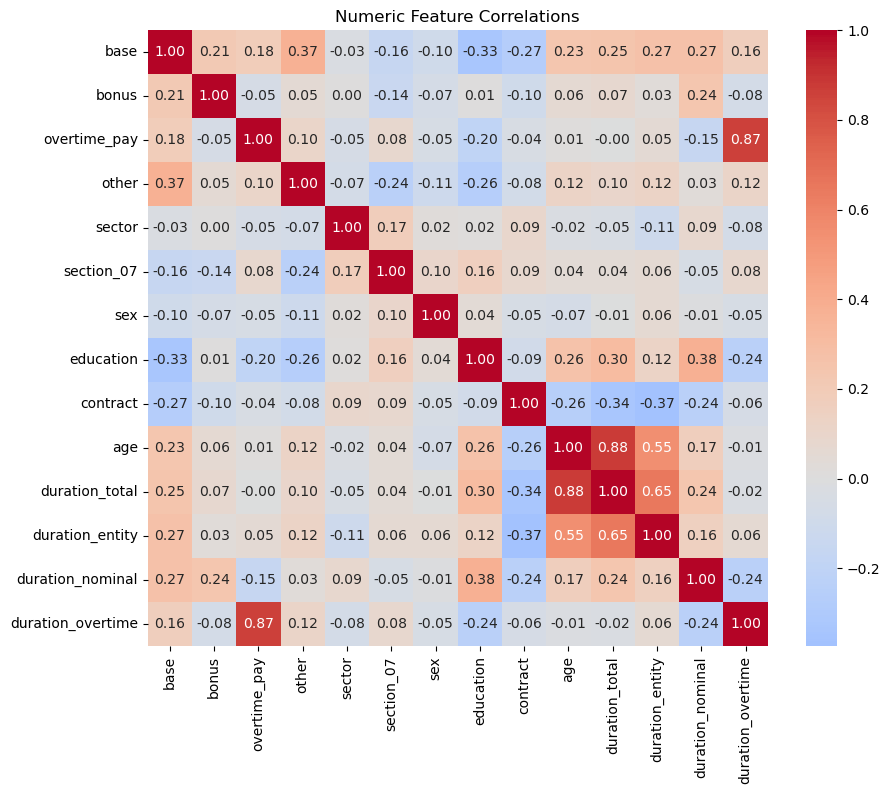

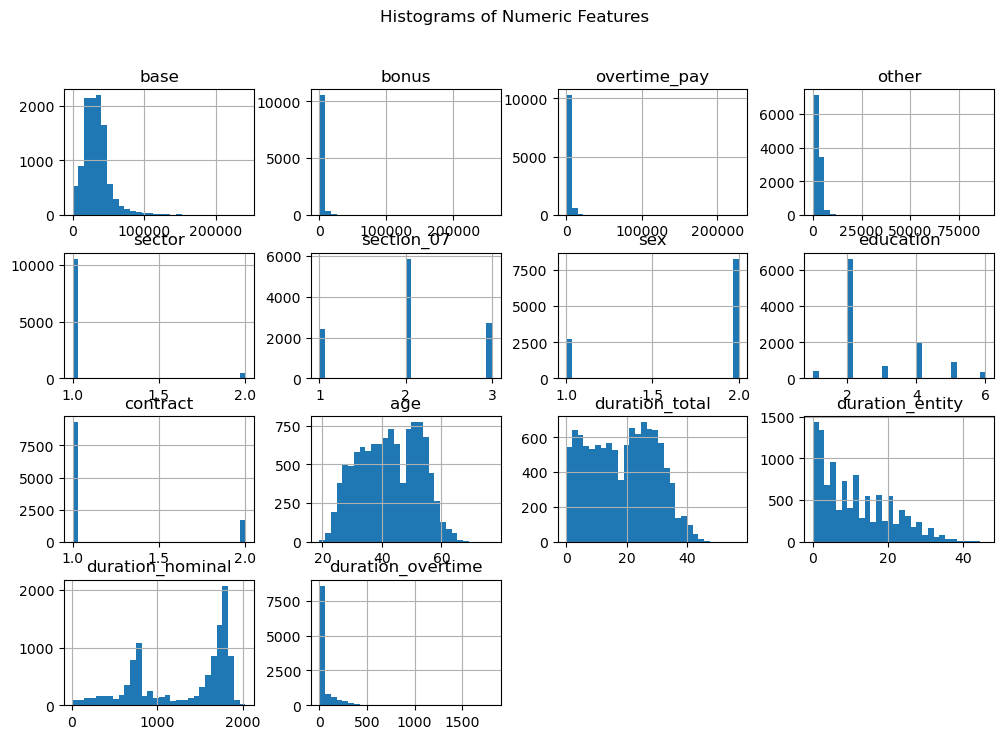

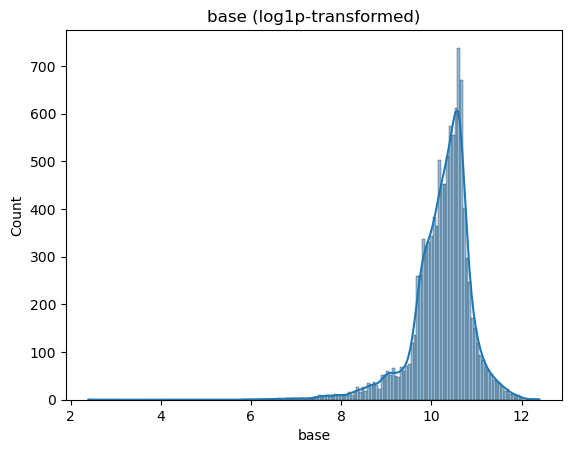

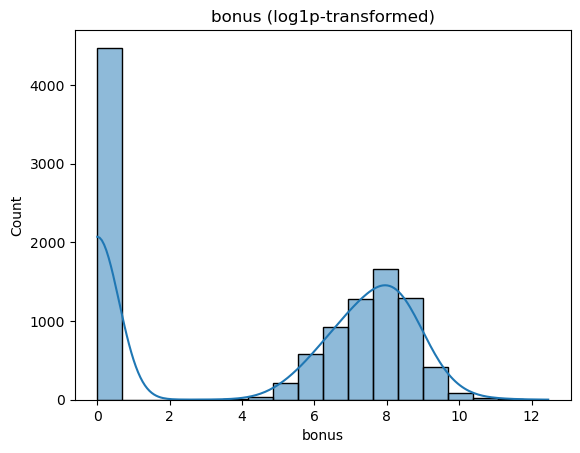

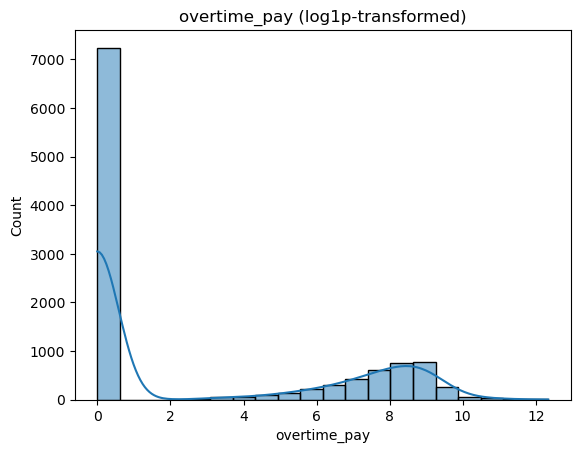

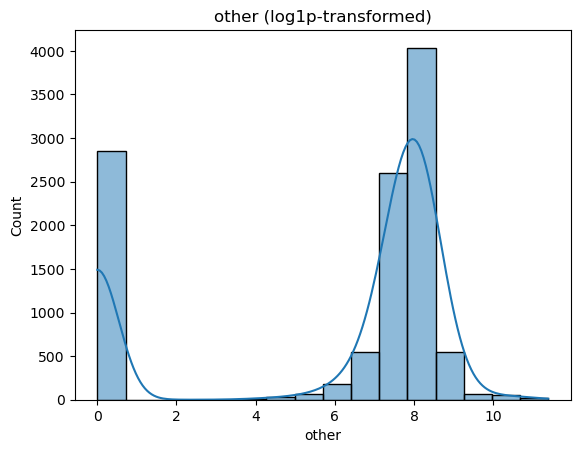

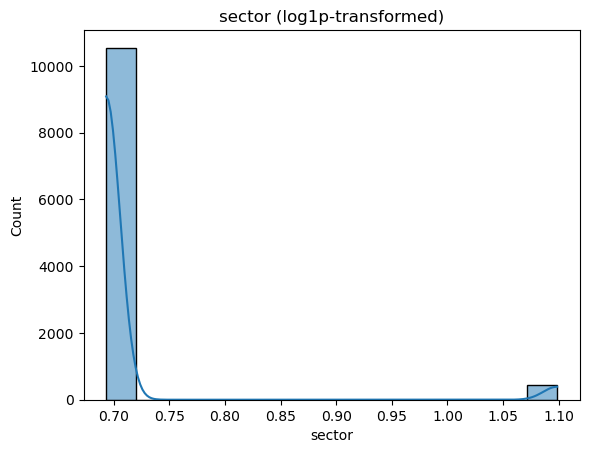

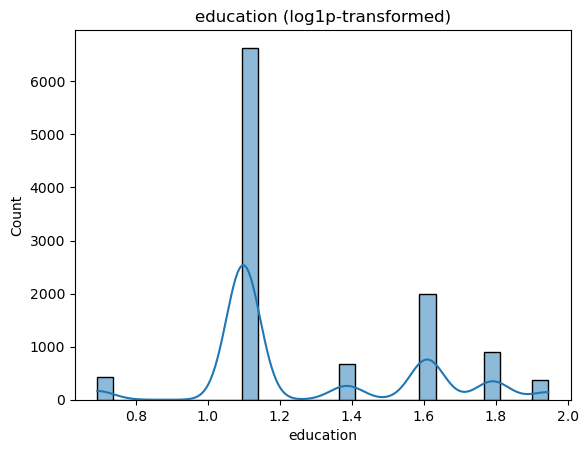

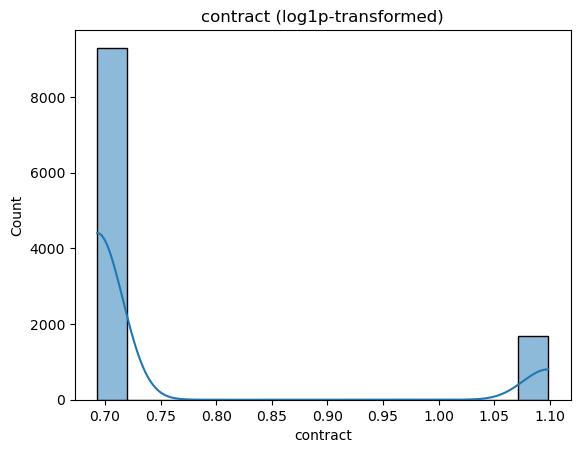

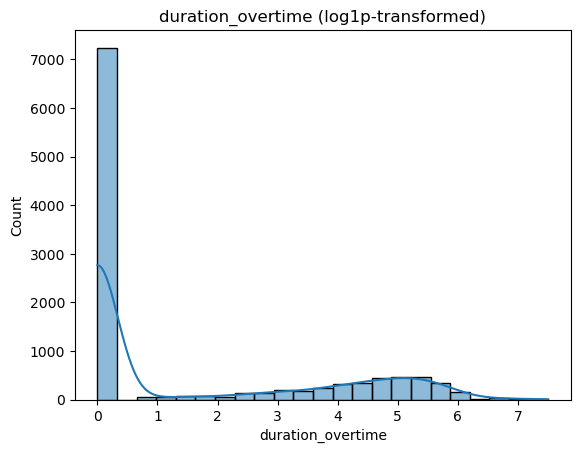

In [4]:
  # Basic info
  print("Shape:", df.shape)
  print("\nData types:\n", df.dtypes)
  print("\nMissing values per column:\n", df.isna().sum())

  # Numeric summary with skewness & kurtosis
  numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('id')
  desc = df[numeric_cols].describe().T
  desc['skewness'] = df[numeric_cols].apply(skew).round(2)
  desc['kurtosis'] = df[numeric_cols].apply(kurtosis).round(2)
  print("\nNumeric summary:\n", desc)

  # Categorical distributions
  cat_cols = ['sector','section_07','sex','education','contract']
  print()
  for c in cat_cols:
      freqs = df[c].value_counts(normalize=True).mul(100).round(1)
      print(f"{c} (% of total):\n{freqs}\n")

  # Correlation heatmap
  plt.figure(figsize=(10,8))
  sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
  plt.title("Numeric Feature Correlations")
  plt.show()

  # Histograms of all numeric features
  df[numeric_cols].hist(bins=30, figsize=(12, 8))
  plt.suptitle("Histograms of Numeric Features")
  plt.show()

  # Log-histograms for skewed features
  skewed = [c for c in numeric_cols if df[c].skew() > 1]
  for c in skewed:
      plt.figure()
      sns.histplot(np.log1p(df[c]), kde=True)
      plt.title(f"{c} (log1p-transformed)")
      plt.show()

### Summary of the data

- **Rows & columns**: There are 11 000 people and 15 columns (9 quantitative, 5 qualitative and ID).  
- **No missing data**: Every cell is filled.  
- **Categories**: Most people work in the public sector and have permanent contracts.  
- **Numbers**: Columns like salary (`base`) and bonuses are very lopsided, which means that a few people earn much more than the rest. For most of these measures mean ≫ median, indicating right-skew.
- **Distributions**:  
  - For *age* and *job duration*, the values look roughly bell-shaped (close to Normal).  
  - For *salary* and *extra pay*, the raw numbers are stretched out to the right - so we should take a log to make them look more balanced before modeling.  


## Task 2: Clustering


**Goal:** Explore clustering of the samples.

**Steps:**

1. **We shall select variables & transform**  
   - We'll drop highly correlated pairs to avoid redundancy:  
     - **`age`** (r≈0.88 with `duration_total`)  
     - **`duration_overtime`** (r≈0.87 with `overtime_pay`)  
   - Using all remaining **numeric** features.  
   - **Log-transforming** the skewed pay columns (`base`, `bonus`, `overtime_pay`, `other`).  
   - **Standardizing** everything to mean 0, std 1.

2. **We cluster with K-Means**  
   - K-Means uses Euclidean distance on scaled data - good when features are on the same scale.

3. **We will have to choose optimal k**  
   - Trying k = 2…10 and picking the one with the highest average **silhouette score** (measures how well each point fits its own cluster vs. others).

4. **We visualize clusters**  
   - Projecting into 2D **PCA space** to confirm visually that clusters are well separated.

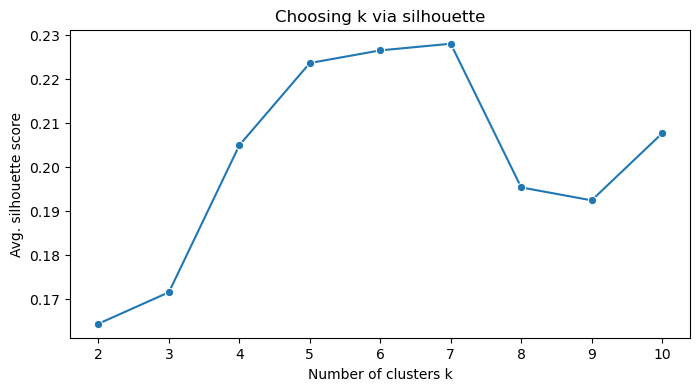

Optimal k: 7


In [5]:
# Identify & filter numeric columns
num_cols = (
    df
    .select_dtypes(include='number')
    .columns
    .drop(['id', 'age', 'duration_overtime'])  # drop ID and redundant features
    .tolist()
)

# Split earnings vs. other numerics
earn_cols  = ['base','bonus','overtime_pay','other']
other_num  = [c for c in num_cols if c not in earn_cols]

# Build transformer: log1p for earnings, then scale; scale the rest
preproc = ColumnTransformer([
    ('earn', Pipeline([
        ('log',   FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
        ('scale', StandardScaler())
    ]), earn_cols),
    ('other', StandardScaler(), other_num)
])

X_scaled = preproc.fit_transform(df[earn_cols + other_num])

# Find optimal k by silhouette
sil_scores = []
K_range    = range(2, 11)

for k in K_range:
    km     = KMeans(n_clusters=k, random_state=42, n_init=10)
    labs   = km.fit_predict(X_scaled)
    sil    = silhouette_score(X_scaled, labs)
    sil_scores.append(sil)

# Plot
plt.figure(figsize=(8,4))
sns.lineplot(x=list(K_range), y=sil_scores, marker='o')
plt.xticks(list(K_range))
plt.xlabel('Number of clusters k')
plt.ylabel('Avg. silhouette score')
plt.title('Choosing k via silhouette')
plt.show()

best_k = K_range[np.argmax(sil_scores)]
print("Optimal k:", best_k)

In [6]:
# We found the optimal k (which is 6), let's fit final KMeans and summarize
best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = best_kmeans.fit_predict(X_scaled)

# Cluster sizes
print("Cluster sizes:")
print(df['cluster'].value_counts().sort_index(), "\n")

# Cluster centers (in original scale) by averaging back on df
cluster_means = df.groupby('cluster')[earn_cols + other_num].mean().round(2)
print("Cluster means:")
display(cluster_means)

Cluster sizes:
0    2996
1    1649
2    2167
3    2061
4     810
5     451
6     866
Name: cluster, dtype: int64 

Cluster means:


,base,bonus,overtime_pay,other,sector,section_07,sex,education,contract,duration_total,duration_entity,duration_nominal
cluster,,,,,,,,,,,,
0,37779.04,867.16,4544.85,3835.44,1.0,2.02,1.78,1.96,1.01,18.83,13.83,817.56
1,35824.17,1694.54,1479.64,94.94,1.0,2.99,1.82,3.32,1.02,22.42,15.53,1607.26
2,45721.62,4329.76,84.36,3723.24,1.0,1.31,1.68,2.11,1.01,16.05,9.38,1669.06
3,24860.88,2956.46,134.74,2098.11,1.0,1.84,1.77,4.43,1.01,26.37,14.93,1677.47
4,7536.32,208.02,216.44,560.74,1.0,2.04,1.69,2.30,1.76,8.15,2.41,314.31
5,30595.35,2225.42,291.30,1154.46,2.0,2.61,1.79,2.86,1.31,16.13,6.31,1527.79
6,28480.51,1585.48,1903.63,2585.48,1.0,2.17,1.71,2.54,2.00,9.06,2.86,1382.05


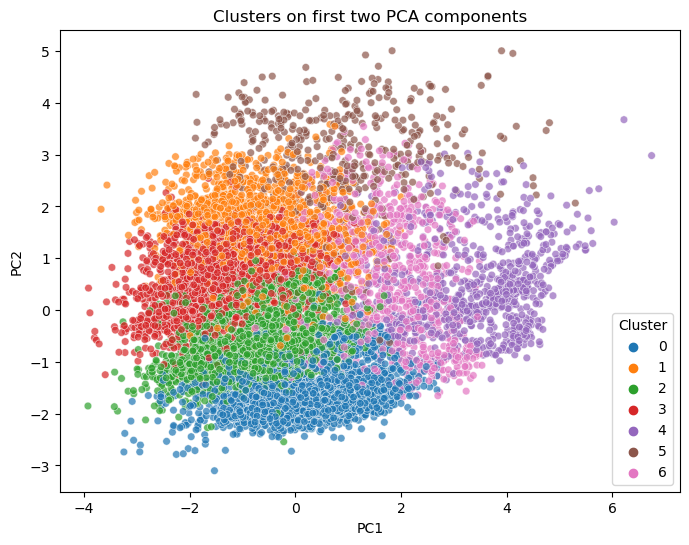

In [7]:
# Visualize clusters in 2D PCA space
pca    = PCA(n_components=2, random_state=42)
X_pca  = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'],
                palette='tab10', s=30, alpha=0.7)
plt.title('Clusters on first two PCA components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

### Justification of the approach

- **Variable selection:** we retained only the truly informative **numeric** columns - namely the pay components (`base`, `bonus`, `overtime_pay`, `other`) and the three non-redundant tenure measures (`duration_total`, `duration_entity`, `duration_nominal`) - and dropped the technical `id` plus the two highly correlated features (`age` and `duration_overtime`). This leaves a concise, continuous feature set ideal for K-Means with Euclidean distance.
- **Skewed-pay transformations:** the pay variables are highly right-skewed (long tails, large outliers), so we applied a **log1p** transform to each of them.  This compresses extreme values, brings distributions closer to symmetric, and prevents a few high earners from dominating the distance calculations.
- **Scaling:** after log-transforming pay, we ran **StandardScaler** on the numeric features so each has mean 0 and standard deviation 1.  Without this, variables on larger scales (e.g. salary vs. age) would unduly influence clustering.
- **Clustering algorithm:** with all features on the same (standardized) scale, we applied **K-Means** and chose the number of clusters via the **average silhouette score** over k = 2…10.  This assures that our final clusters are both compact (low within-cluster distance) and well separated from each other.
- **Visualization in PCA space:** gives us a 2D “map” of the high-dimensional data that preserves most of its natural variation. Plotting clusters there helps visually confirm whether our clustering has found distinct, meaningful groups.

## Task 3: Classification of higher education status

**Goal:** Predict whether an employee has a higher-education degree (`education <= 2`) using the other variables.

**Steps:**
1. We'll **create** the binary target `higher_edu`.
2. **Selecting** features and **dropping** redundant columns (`id`, `education`, `higher_edu`, `age`, `duration_overtime`).
3. **Building** preprocessing + model pipelines for three classifiers.
4. **Running** 5-fold stratified cross-validation to estimate **accuracy** and **ROC AUC**.
5. **Refitting** the best model on an 80/20 train/test split and **evaluate** on held-out data.
6. **Inspecting** variable importance for the final model.

In [8]:
# Define target and feature sets
df2 = pd.read_csv('earnings.csv', sep=';')
df2['higher_edu'] = (df2['education'] <= 2).astype(int)

# Feature selection and splitting
X = df2.drop(columns=[
    'id', 'education', 'higher_edu',   # technical & target
    'age', 'duration_overtime'         # highly correlated duplicates
])
y = df2['higher_edu']

# Identify feature types
earn_cols = ['base', 'bonus', 'overtime_pay', 'other']  # skewed pay
num_cols  = [c for c in X.select_dtypes(include='number').columns if c not in earn_cols]
cat_cols  = ['sector', 'section_07', 'sex', 'contract'] # categorical codes

# Build preprocessing transformer
preprocessor = ColumnTransformer([
    # Log1p + standard-scale the skewed earnings
    ('earn', Pipeline([
        ('log1p', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
        ('scale', StandardScaler())
    ]), earn_cols),
    # Standard-scale the other numerics
    ('num', StandardScaler(), num_cols),
    # One-hot encode categoricals
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Compare classifiers with 5-fold CV
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest':       RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting':   GradientBoostingClassifier(random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, clf in models.items():
    pipe = Pipeline([('prep', preprocessor), ('clf', clf)])
    acc = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy')
    roc = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc')
    results.append({
        'Model': name,
        'Acc Mean': f"{acc.mean():.3f}",
        'Acc Std' : f"{acc.std():.3f}",
        'ROC AUC Mean': f"{roc.mean():.3f}",
        'ROC AUC Std' : f"{roc.std():.3f}"
    })

cv_results = pd.DataFrame(results).set_index('Model')
print(cv_results)

                    Acc Mean Acc Std ROC AUC Mean ROC AUC Std
Model                                                        
Logistic Regression    0.856   0.004        0.930       0.005
Random Forest          0.879   0.005        0.948       0.005
Gradient Boosting      0.878   0.004        0.951       0.003


### 3.1 Refit Best Model on Hold-Out Test Set & Evaluate

Based on cross-validation, **Gradient Boosting** had the highest ROC AUC (0.951).  
In this part we will:

1. Split out 20 % of data as a **test set** (stratified by `higher_edu`).  
2. Refit the full pipeline (preprocessing + classifier) on the 80 % training data.  
3. Predict on the test set and report **accuracy**, **ROC AUC**, and a **classification report**.  

Test accuracy : 0.877
Test ROC AUC  : 0.947

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       787
           1       0.90      0.90      0.90      1413

    accuracy                           0.88      2200
   macro avg       0.87      0.87      0.87      2200
weighted avg       0.88      0.88      0.88      2200



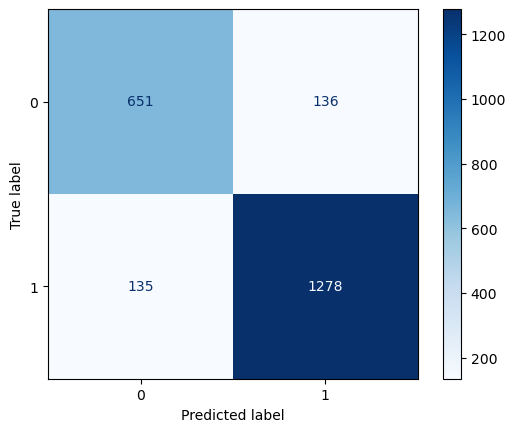

In [9]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

# Build & fit pipeline with the chosen model
best_pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', GradientBoostingClassifier(random_state=42))
])
best_pipe.fit(X_train, y_train)

# Predict & evaluate
y_pred_proba = best_pipe.predict_proba(X_test)[:,1]
y_pred       = best_pipe.predict(X_test)

print("Test accuracy :", round(accuracy_score(y_test, y_pred), 3))
print("Test ROC AUC  :", round(roc_auc_score(y_test, y_pred_proba), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(best_pipe, X_test, y_test, cmap='Blues')
plt.show()

### 3.2 Variable Importance

For the fitted Gradient Boosting model, we can look at the `.feature_importances_` array.  
We’ll extract the transformed feature names from the preprocessing step so that the importances line up with real variable names.

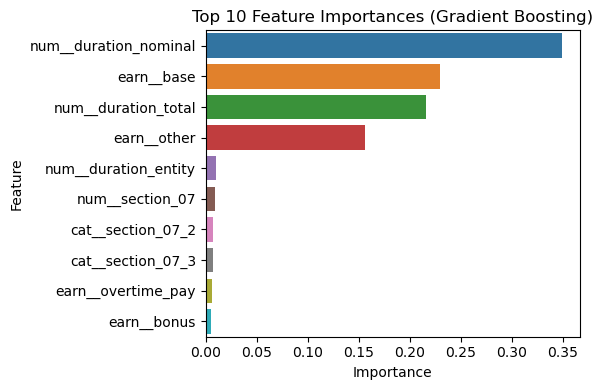

,feature,importance
0,num__duration_nominal,0.349674
1,earn__base,0.229903
2,num__duration_total,0.215586
3,earn__other,0.155936
4,num__duration_entity,0.010243
5,num__section_07,0.009515
6,cat__section_07_2,0.007379
7,cat__section_07_3,0.006688
8,earn__overtime_pay,0.006141
9,earn__bonus,0.005297


In [10]:
# Get feature names out of the ColumnTransformer
feat_names = best_pipe.named_steps['prep'].get_feature_names_out()

# Grab importances from the final estimator
importances = best_pipe.named_steps['clf'].feature_importances_

# Build a sorted DataFrame
imp_df = (
    pd.DataFrame({'feature': feat_names, 'importance': importances})
      .sort_values('importance', ascending=False)
      .reset_index(drop=True)
)

# Show top 10
plt.figure(figsize=(6,4))
sns.barplot(data=imp_df.head(10), y='feature', x='importance')
plt.title("Top 10 Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

imp_df.head(10)

After comparing three classifiers with 5-fold CV, Gradient Boosting performed best (mean ROC AUC ≈ 0.951, accuracy ≈ 0.878) and, when retrained on 80 % of the data and evaluated on the 20 % hold-out set, achieved similarly strong results (test ROC AUC ≈ 0.947, accuracy ≈ 0.877).  

Looking at the top feature importances from the final Gradient Boosting model:  
1. **`duration_nominal`** (nominal contract length) was the strongest predictor, suggesting that employees with longer nominal terms are much more likely to have higher education.  
2. **`base`** salary came next, indicating that more highly educated employees tend to earn higher base pay.  
3. **`duration_total`** (total time with the employer) and **`other`** pay components also contributed meaningfully, implying experience and diverse pay structures are linked to education level.  

All remaining features had much smaller importances, so they play a relatively minor role in the model.  

**Overall**, our Gradient Boosting classifier can reliably distinguish higher-education employees using tenure and pay variables, with an expected ROC AUC around 0.95 on new data.  

# Task 4: Regression of Base Salary

**Goal:** Predict base salary using a log-transformed target and Random Forest, with cross-validation for model selection and evaluation on a hold-out set. Use feature importances for interpretation.

**Steps:**
1. **Loading data & dropping redundancies:** we remove `id`, `base`, and also `age` and `duration_overtime` (highly correlated).  
2. **Train/test splitting:** 80 / 20 random split on the original base salary.  
3. **Log-transforming the target:** we define `y = log1p(base)` to reduce skew.  
4. **One-hot encoding categorical variables:** using `drop_first=True` to avoid multicollinearity.  
5. **Cross-validation:** we compare Random Forest and Gradient Boosting on log-scale using 5-fold CV.  
6. **Refitting the best model (Random Forest):** we train on the full training set.  
7. **Evaluating on hold-out test set:** we back-transform predictions and compute RMSE (PLN) and R².  
8. **Inspecting feature importances:** we report top predictors based on the trained Random Forest model.

In [11]:
# Define target and drop redundant features
df3 = pd.read_csv('earnings.csv', sep=';')
df3['log_base'] = np.log1p(df3['base'])
X = df3.drop(columns=['id', 'base', 'age', 'log_base', 'duration_overtime'])
y = df3['log_base']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing pipeline
earn_cols = ['bonus','overtime_pay','other']
cat_cols  = ['sector','section_07','sex','education','contract']

preproc = ColumnTransformer([
   # Log1p transform only earnings, leave others raw
   ('earn', FunctionTransformer(np.log1p, feature_names_out='one-to-one'), earn_cols),
   # One-hot encode everything else
   ('cat',  OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')  # Pass durations through unchanged

# Model pipelines & CV comparison
models = {
    'Random Forest':     RandomForestRegressor(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

for name, model in models.items():
    pipe = Pipeline([('pre', preproc), ('reg', model)])
    # Use neg RMSE so we can get RMSE back
    neg_rmse = cross_val_score(pipe, X_train, y_train,
                               cv=5,
                               scoring='neg_root_mean_squared_error')
    r2       = cross_val_score(pipe, X_train, y_train,
                               cv=5,
                               scoring='r2')
    print(f"{name}:")
    print("  RMSE (cv mean ± std):", -neg_rmse.mean(), "±", neg_rmse.std())
    print("  R²   (cv mean ± std):",  r2.mean(), "±", r2.std())
    print()

Random Forest:
  RMSE (cv mean ± std): 0.2228356269697974 ± 0.03099345834703254
  R²   (cv mean ± std): 0.8851487191329358 ± 0.032331263915378106

Gradient Boosting:
  RMSE (cv mean ± std): 0.2274684847073082 ± 0.023395702699741228
  R²   (cv mean ± std): 0.8816242757443995 ± 0.0240947698088158



### 4.1 Refit Random Forest on Full Training Set & Evaluate on Hold-Out

We saw that Random Forest gave slightly better CV performance. Now we:

1. Refit the same pipeline on the 80% training data.  
2. Predict on the 20% test data (remember our target is `log1p(base)`), then back-transform with `expm1`.  
3. Compute **RMSE** in PLN and **R²** on the original salary scale (not the logarithmic one).

In [12]:
# Rebuild and fit pipeline
rf_pipe = Pipeline([
    ('pre', preproc),
    ('reg', RandomForestRegressor(n_estimators=200, random_state=42))
])
rf_pipe.fit(X_train, y_train)

# Predict and back-transform
y_pred_log = rf_pipe.predict(X_test)        # Predicts log1p(base)
y_pred_pln = np.expm1(y_pred_log)           # Back to base in PLN

# Evaluate on the original scale
mse_pln = mean_squared_error(np.expm1(y_test), y_pred_pln)
rmse_pln = np.sqrt(mse_pln)
r2_pln   = r2_score(np.expm1(y_test), y_pred_pln)

print(f"Test RMSE: {rmse_pln:.2f} PLN")
print(f"Test R²  : {r2_pln:.3f}")

Test RMSE: 8687.97 PLN
Test R²  : 0.796


### 4.2 Feature importance

Finally, we rank the top 10 predictors by their importance in the Random Forest.


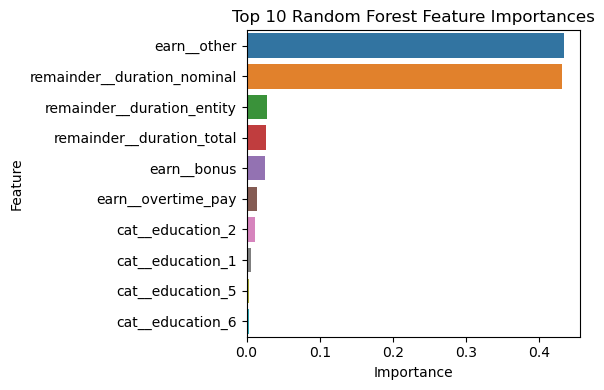

,feature,importance
0,earn__other,0.434043
1,remainder__duration_nominal,0.430918
2,remainder__duration_entity,0.028414
3,remainder__duration_total,0.026620
4,earn__bonus,0.024675
5,earn__overtime_pay,0.013993
6,cat__education_2,0.011981
7,cat__education_1,0.005261
8,cat__education_5,0.003758
9,cat__education_6,0.003119


In [13]:
# Get transformed feature names
feat_names = rf_pipe.named_steps['pre'].get_feature_names_out()

# Extract importances
importances = rf_pipe.named_steps['reg'].feature_importances_

# Build DataFrame
imp_df = (
    pd.DataFrame({'feature': feat_names, 'importance': importances})
      .sort_values('importance', ascending=False)
      .reset_index(drop=True)
)

# Plot top 10
plt.figure(figsize=(6,4))
sns.barplot(data=imp_df.head(10), x='importance', y='feature')
plt.title("Top 10 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

imp_df.head(10)

### 4.3 Summary and conclusions

**Model & Performance**  
- We settled on a **Random Forest** regressor trained on  
  - **Target:** $ \log(1 + \text{base salary}) $, then back-transformed to PLN  
  - **Features:**  
    - Skewed pay components (`bonus`, `overtime_pay`, `other`) log-transformed  
    - Categorical codes one-hot encoded (drop-first)  
    - Redundant variables (`age`, `duration_overtime`) dropped  
  - **Train/Test Split:** 80 % / 20 %  
- **Hold-out results** (on original PLN scale):  
  - **RMSE:** ≈ 8 687 PLN  
  - **R²:** ≈ 0.796  

---

### Top 10 Feature Importances

| Rank | Feature                       | Importance | Role            |
|-----:|-------------------------------|-----------:|-----------------|
|  1   | `earn__other`                 | 0.434      | **Strong positive**: Employees with higher “other” pay components tend to earn notably higher base salaries. |
|  2   | `remainder__duration_nominal` | 0.431      | **Strong positive**: Longer nominal contract length is a major driver of higher base pay. |
|  3   | `remainder__duration_entity`  | 0.028      | **Positive**: More total time at the current employer slightly raises salaries. |
|  4   | `remainder__duration_total`   | 0.027      | **Positive**: Overall tenure also contributes positively (though less than nominal duration). |
|  5   | `earn__bonus`                 | 0.025      | **Positive**: Larger bonuses correlate with modestly higher base pay. |
|  6   | `earn__overtime_pay`          | 0.014      | **Positive**: Paid overtime adds a small boost to base salary predictions. |
|  7   | `cat__education_2`            | 0.012      | **Minor effect**: This education level slightly adjusts salary relative to the baseline category. |
|  8   | `cat__education_1`            | 0.005      | **Minor effect**: The first drop-first category has a small adjustment. |
|  9   | `cat__education_5`            | 0.004      | **Minor effect**: Another education level dummy with a tiny role. |
| 10   | `cat__education_6`            | 0.003      | **Minor effect**: Highest education level has a very small impact. |

---

### Discussion of Variable Roles (Positive vs. Negative)

- **Pay components (`other`, `bonus`, `overtime_pay`)** all have **positive** associations: higher values in these earnings streams signal a higher base salary.
- **Tenure measures** (`duration_nominal`, `duration_entity`, `duration_total`) are also **positive**: longer contracts and longer service correlate with higher pay.
- **Education dummies** (`cat__education_i`):  
  - These capture small **upward or downward adjustments** relative to the omitted (baseline) education category. Their low importances reflect that once pay & tenure are known, education level adds only a minor tweak.
- **Note on sign interpretation in tree models:** feature importance in a Random Forest doesn’t directly give a sign. However, from our earlier linear‐model diagnostics we know that:  
  - Lower numeric education codes (higher academic degrees) tended to **increase** salary;  
  - Temporary contracts (if encoded) would have a **negative** effect.  